In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

# Убедимся, что TensorFlow использует GPU (если доступен)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU доступен: {physical_devices}")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("GPU не найден, используется CPU.")

TensorFlow version: 2.18.0
GPU не найден, используется CPU.


In [2]:
 tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import tensorflow as tf
import os

def create_denoising_dataset_v4(noisy_folders, clean_folders, image_size=(128, 128), batch_size=20):
    """
    Создает tf.data.Dataset для задачи денойзинга изображений, где каждому шумному изображению
    из нескольких папок сопоставляется чистое изображение с таким же именем из соответствующей папки.
    
    Аргументы:
    - noisy_folders: список путей к папкам с шумными изображениями.
    - clean_folders: список путей к папкам с чистыми изображениями.
    - image_size: кортеж с размером изображений (по умолчанию (128, 128)).
    - batch_size: размер батча (по умолчанию 20).
    
    Возвращает:
    - tf.data.Dataset, где входы — шумные изображения, а выходы — чистые изображения.
    """
    def load_image(image_path):
        """Загружает и нормализует изображение."""
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=1)  # Градации серого
        image = tf.image.resize(image, image_size)  # Изменение размера
        image = tf.cast(image, tf.float32) / 255.0  # Нормализация в диапазон [0, 1]
        return image

    noisy_image_paths = []
    clean_image_paths = []

    # Обрабатываем каждую пару папок
    for noisy_folder, clean_folder in zip(noisy_folders, clean_folders):
        # Получаем списки файлов
        noisy_paths = tf.io.gfile.glob(os.path.join(noisy_folder, "*.png"))
        clean_paths = tf.io.gfile.glob(os.path.join(clean_folder, "*.png"))

        # Создаем словарь для чистых изображений
        clean_image_dict = {os.path.basename(path): path for path in clean_paths}

        # Сопоставляем шумные изображения с чистыми
        for noisy_path in noisy_paths:
            noisy_filename = os.path.basename(noisy_path)
            clean_path = clean_image_dict.get(noisy_filename)
            if clean_path:  # Если чистое изображение существует
                noisy_image_paths.append(noisy_path)
                clean_image_paths.append(clean_path)

    # Убеждаемся, что количество шумных и чистых изображений совпадает
    assert len(noisy_image_paths) == len(clean_image_paths), "Не все шумные изображения имеют соответствующее чистое изображение!"

    # Создаем датасеты
    noisy_dataset = tf.data.Dataset.from_tensor_slices(noisy_image_paths).map(
        lambda path: load_image(path),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    clean_dataset = tf.data.Dataset.from_tensor_slices(clean_image_paths).map(
        lambda path: load_image(path),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Объединяем шумные изображения (вход) с чистыми (выход)
    dataset = tf.data.Dataset.zip((noisy_dataset, clean_dataset))

    # Перемешивание и разбиение на батчи
    dataset = dataset.shuffle(buffer_size=len(noisy_image_paths)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


In [4]:
noisy_folders = [
    "DATASETS/DATASET_3/fig1/noize/", 
    "DATASETS/DATASET_3/fig2/noize/",  
    "DATASETS/DATASET_3/fig3/noize/"
]

clean_folders = [
    "DATASETS/DATASET_3/fig1/clear/", 
    "DATASETS/DATASET_3/fig2/clear/",  
    "DATASETS/DATASET_3/fig3/clear/"
]

### РАЗМЕРНОСТЬ ИЗОБРАЖЕНИЯ И БАТЧА ###

BUTCH_SIZE = 1 # Butch size
IMG_SIZE = (128, 128)  # Img Size


dataset = create_denoising_dataset_v4(noisy_folders, clean_folders, image_size=IMG_SIZE, batch_size=BUTCH_SIZE)

# Проверка
DATA_LENGHT = len(list(dataset))
print("Кол-во изображений: ", DATA_LENGHT)
for noisy_images, clean_images in dataset.take(1):
    print("Размер входного батча:", noisy_images.shape)
    print("Размер выходного батча:", clean_images.shape)


Кол-во изображений:  2079
Размер входного батча: (1, 128, 128, 1)
Размер выходного батча: (1, 128, 128, 1)


In [5]:
import matplotlib.pyplot as plt

def display_noisy_clean_grid(noisy_images, clean_images, title="Noisy vs Clean", rows=5):
    """
    Отображает зашумленные и чистые изображения в виде таблицы.
    Каждая строка содержит парные изображения: зашумленное и чистое.
    
    Аргументы:
    - noisy_images: список или тензор зашумленных изображений (N, H, W, C).
    - clean_images: список или тензор чистых изображений (N, H, W, C).
    - title: заголовок таблицы (по умолчанию "Noisy vs Clean").
    - rows: количество строк в таблице (по умолчанию 5).
    """
    # Если батч содержит одно изображение, добавляем ось для совместимости
    if len(noisy_images.shape) == 3:  # (H, W, C)
        noisy_images = noisy_images[None, ...]  # Добавляем ось (1, H, W, C)
    if len(clean_images.shape) == 3:  # (H, W, C)
        clean_images = clean_images[None, ...]

    cols = 2  # Каждый пример содержит два изображения: зашумленное и чистое
    total_images = min(len(noisy_images), len(clean_images), rows)
    
    # Преобразуем тензоры в numpy (если нужно)
    if tf.is_tensor(noisy_images):
        noisy_images = noisy_images.numpy()
    if tf.is_tensor(clean_images):
        clean_images = clean_images.numpy()

    # Создаем фигуру
    fig, axes = plt.subplots(total_images, cols, figsize=(5, 3 * total_images))
    fig.suptitle(title, fontsize=16)

    # Обрабатываем случай с единственной строкой (total_images = 1)
    if total_images == 1:
        axes = [axes]  # Преобразуем в список для унифицированной обработки

    # Отображаем изображения
    for i in range(total_images):
        # Зашумленное изображение
        axes[i][0].imshow(noisy_images[i], cmap='gray')
        axes[i][0].set_title("Noisy")
        axes[i][0].axis("off")

        # Чистое изображение
        axes[i][1].imshow(clean_images[i], cmap='gray')
        axes[i][1].set_title("Clean")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



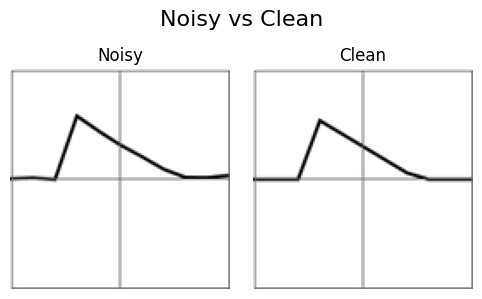

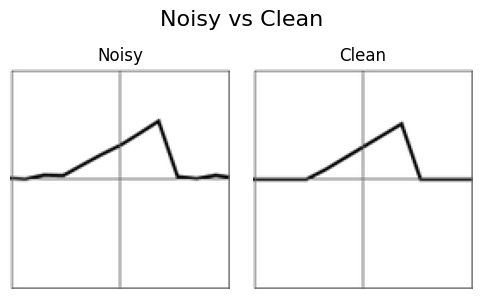

In [6]:
# Взять один батч из датасета
for noisy_images, clean_images in dataset.take(2):
    # Ограничиваем выборку первыми 5 парами
    noisy_images_5 = noisy_images[:5]
    clean_images_5 = clean_images[:5]

    # Отображаем пары изображений
    display_noisy_clean_grid(noisy_images_5, clean_images_5, title="Noisy vs Clean")


In [7]:
import tensorflow as tf

# Задаем входную форму изображения
BUTCH_SIZE = 1
input_shape = (IMG_SIZE[0], IMG_SIZE[1], BUTCH_SIZE)  # Например, 128x128 RGB изображения

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization

# Модель для денойзинга изображений
model = Sequential([
    # Encoder: Сверточные слои для извлечения признаков
    Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    
    # Decoder: Декодирующие слои для восстановления изображений
    Conv2D(128, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    UpSampling2D(size=2),
    
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    BatchNormalization(),
    UpSampling2D(size=2),
    
    # Выходной слой с одним каналом (черно-белое изображение)
    Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()



C:\Users\gerce\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 1)    │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,985 (1.14 MB)

 Trainable params: 297,217 (1.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [9]:
# Предположим, что dataset уже создан, например, как выше:
# dataset содержит пары (noisy_images, clean_images)

# Разделим датасет на обучающую и валидационную выборки
train_dataset = dataset.take(round(0.8 * DATA_LENGHT))  # 80% данных для обучения
val_dataset = dataset.skip(round(0.8 * DATA_LENGHT)).take(round(0.2 * DATA_LENGHT) - 1)  # 20% данных для валидации

# Добавляем батчирование и опциональное перемешивание
train_dataset = train_dataset.shuffle(buffer_size=100).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

TRAIN_DATA_LENGHT = len(list(train_dataset))
VAL_DATA_LENGHT = len(list(val_dataset))

print("Кол-во изображений TRAIN: ", TRAIN_DATA_LENGHT)
print("Кол-во изображений   VAL: ", VAL_DATA_LENGHT)


Кол-во изображений TRAIN:  1663
Кол-во изображений   VAL:  415


In [44]:
for noisy_images, clean_images in train_dataset.take(1):
    print("Noisy shape:", noisy_images.shape)
    print("Clean shape:", clean_images.shape)


Noisy shape: (1, 128, 128, 1)
Clean shape: (1, 128, 128, 1)


In [10]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=2
)


Epoch 1/5
1663/1663 - 127s - 76ms/step - loss: 0.0084 - mae: 0.0299 - val_loss: 0.0722 - val_mae: 0.2023
Epoch 2/5
1663/1663 - 126s - 76ms/step - loss: 0.0015 - mae: 0.0103 - val_loss: 0.0013 - val_mae: 0.0091
Epoch 3/5
1663/1663 - 127s - 76ms/step - loss: 0.0013 - mae: 0.0086 - val_loss: 0.0373 - val_mae: 0.1306
Epoch 4/5
1663/1663 - 126s - 76ms/step - loss: 0.0012 - mae: 0.0078 - val_loss: 0.0014 - val_mae: 0.0084
Epoch 5/5
1663/1663 - 165s - 99ms/step - loss: 0.0011 - mae: 0.0071 - val_loss: 0.0117 - val_mae: 0.0882


In [11]:
# Оценка модели на валидационном датасете
loss, mae = model.evaluate(val_dataset)
print(f"Loss на валидации: {loss:.4f}")
print(f"Mean Absolute Error на валидации: {mae:.4f}")


415/415 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0117 - mae: 0.0880
Loss на валидации: 0.0118
Mean Absolute Error на валидации: 0.0882


In [12]:
# # Взять один батч из валидационного датасета
# for noisy_images, clean_images in val_dataset.take(20):
#     # Предсказание модели
#     predicted_images = model.predict(noisy_images)
#     
#     # Отображение
#     print("Визуализация предсказаний:")
#     display_noisy_clean_grid(noisy_images, clean_images, title="Noisy vs Clean (Ground Truth)")
#     display_noisy_clean_grid(noisy_images, predicted_images, title="Noisy vs Clean (Predicted)")


In [13]:
# import numpy as np
# 
# # Взять один батч из валидационного датасета
# for noisy_images, clean_images in val_dataset.take(1):
#     predicted_images = model.predict(noisy_images)
#     
#     # Вычислить MSE и MAE
#     mse = np.mean((predicted_images - clean_images.numpy())**2)
#     mae = np.mean(np.abs(predicted_images - clean_images.numpy()))
#     print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
#     print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")


In [14]:
# for noisy_images, clean_images in val_dataset.take(2):
#     fig, axes = plt.subplots(1, 1, figsize=(5, 5))
#     image = clean_images
#     axes.imshow(image.numpy().squeeze(), cmap='gray')

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_image(model, image_path, image_size=(128, 128)):
    """
    Прогоняет изображение через модель для получения предсказания.
    
    Аргументы:
    - model: обученная модель.
    - image_path: путь к изображению.
    - image_size: размер, до которого изображение будет приведено (по умолчанию 128x128).
    
    Вывод:
    - Отображает оригинальное изображение, зашумленное и предсказанное изображение.
    """
    # Шаг 1: Загрузка изображения
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  # Градации серого
    image = tf.image.resize(image, IMG_SIZE)  # Изменение размера
    image = tf.cast(image, tf.float32) / 255.0  # Нормализация в диапазон [0, 1]
    
    # Добавляем дополнительную ось для батча (нужно для модели)
    noisy_image = tf.expand_dims(image, axis=0)

    # Шаг 2: Прогоняем через модель
    predicted_image = model.predict(noisy_image)

    # Шаг 3: Отображение изображений
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle("Check predictions NW", fontsize=16)

    # Оригинальное изображение (чистое)
    axes[0].imshow(image.numpy().squeeze(), cmap='gray')
    axes[0].set_title("INPUT")
    axes[0].axis("off")

    # Зашумленное изображение
    # axes[1].imshow(noisy_image.numpy().squeeze(), cmap='gray')
    # axes[1].set_title("NW's img")
    # axes[1].axis("off")

    # Предсказанное изображение
    axes[1].imshow(predicted_image.squeeze(), cmap='gray')
    axes[1].set_title("OUTPUT")
    axes[1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [17]:
def predict_image_with_losses(model, image_path, clean_image_path, image_size=(128, 128)):
    """
    Прогоняет изображение через модель и отображает его с предсказанием, значением функции потерь для входного и выходного изображения.
    
    Аргументы:
    - model: обученная модель.
    - image_path: путь к зашумленному изображению.
    - clean_image_path: путь к чистому изображению.
    - image_size: размер, до которого изображение будет приведено (по умолчанию 128x128).
    """
    # Загрузка и обработка зашумленного изображения
    noisy_image = tf.io.read_file(image_path)
    noisy_image = tf.image.decode_png(noisy_image, channels=1)
    noisy_image = tf.image.resize(noisy_image, image_size)
    noisy_image = tf.cast(noisy_image, tf.float32) / 255.0
    noisy_image_batch = tf.expand_dims(noisy_image, axis=0)  # Для модели

    # Загрузка и обработка чистого изображения
    clean_image = tf.io.read_file(clean_image_path)
    clean_image = tf.image.decode_png(clean_image, channels=1)
    clean_image = tf.image.resize(clean_image, image_size)
    clean_image = tf.cast(clean_image, tf.float32) / 255.0

    # Прогоняем через модель
    predicted_image = model.predict(noisy_image_batch)[0]

    # Вычисление функций потерь (MSE) для входного и выходного изображения
    mse_input = tf.keras.losses.MeanSquaredError()(clean_image, noisy_image).numpy()
    mse_output = tf.keras.losses.MeanSquaredError()(clean_image, predicted_image).numpy()
    kappa = mse_input - mse_output
    psi = mse_input / mse_output

    # Отображение изображений
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"L_in: {mse_input:.4f}, L_out: {mse_output:.4f}, kappa: {kappa}, psi: {psi}", fontsize=16)

    # Входное зашумленное изображение
    axes[0].imshow(noisy_image.numpy().squeeze(), cmap='gray')
    axes[0].set_title("Noisy Input")
    axes[0].axis("off")

    # Истинное изображение
    # axes[1].imshow(clean_image.numpy().squeeze(), cmap='gray')
    # axes[1].set_title("Clean Image")
    # axes[1].axis("off")

    # Предсказанное изображение
    axes[1].imshow(predicted_image.squeeze(), cmap='gray')
    axes[1].set_title("Predicted Output")
    axes[1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 801ms/step


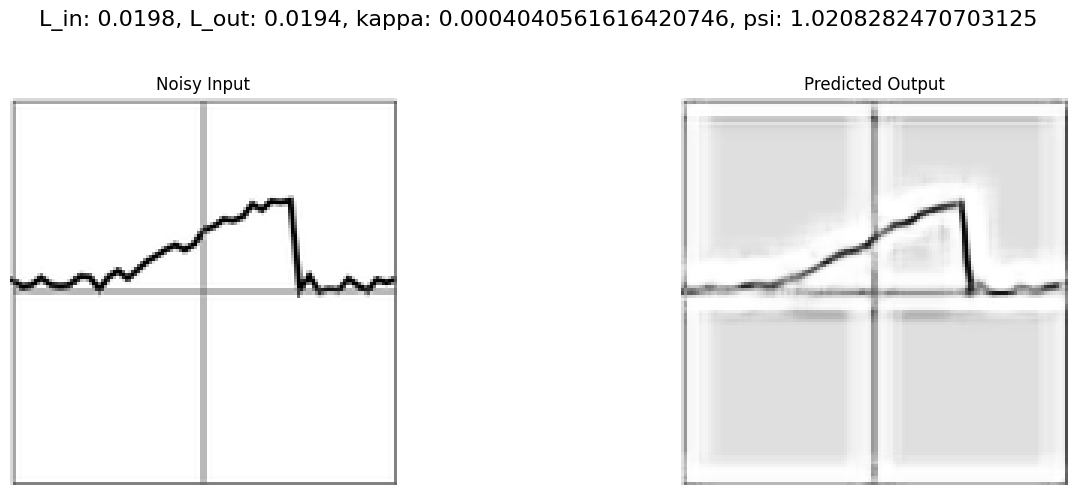

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


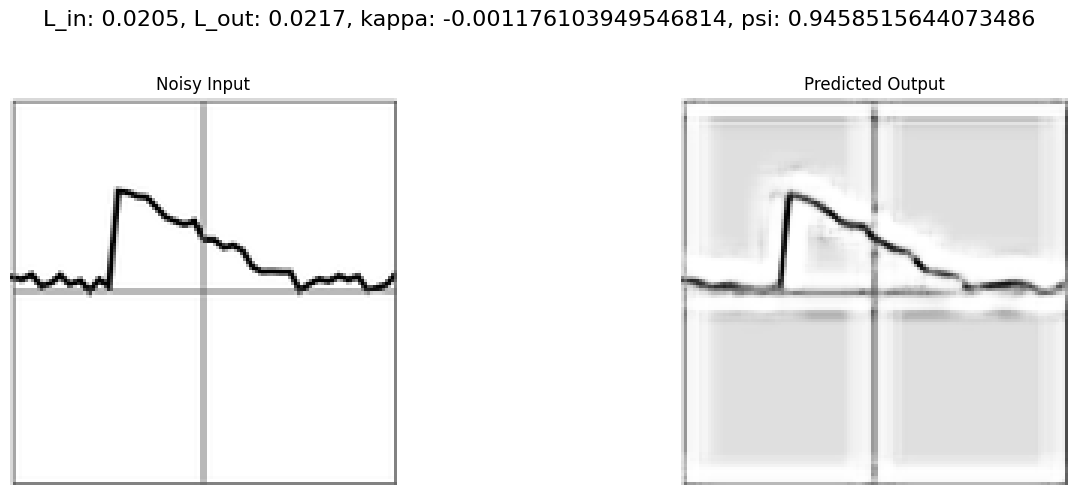

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


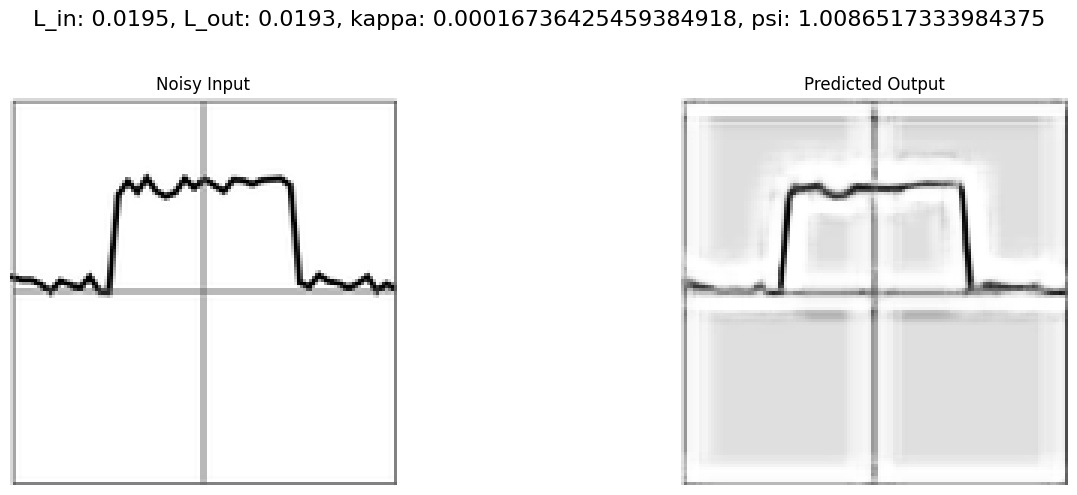

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


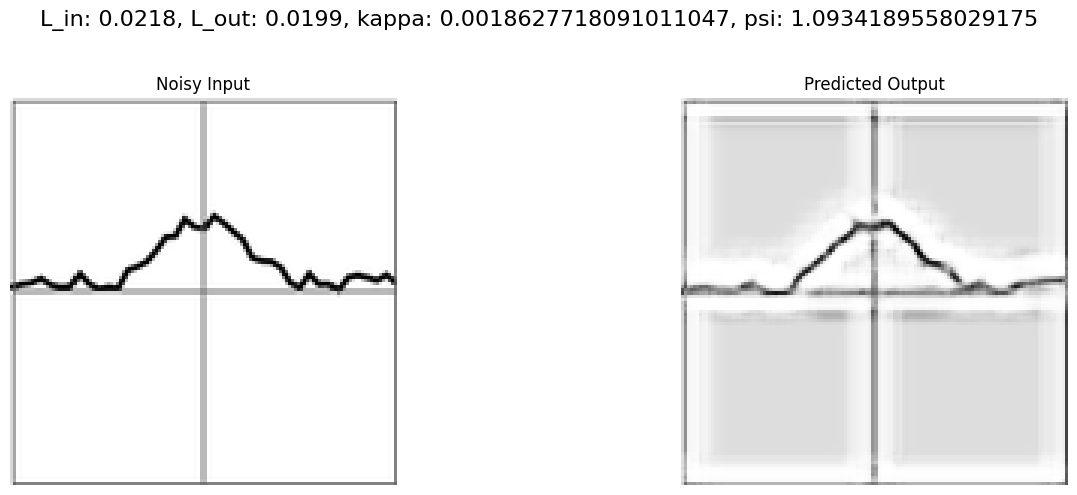

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


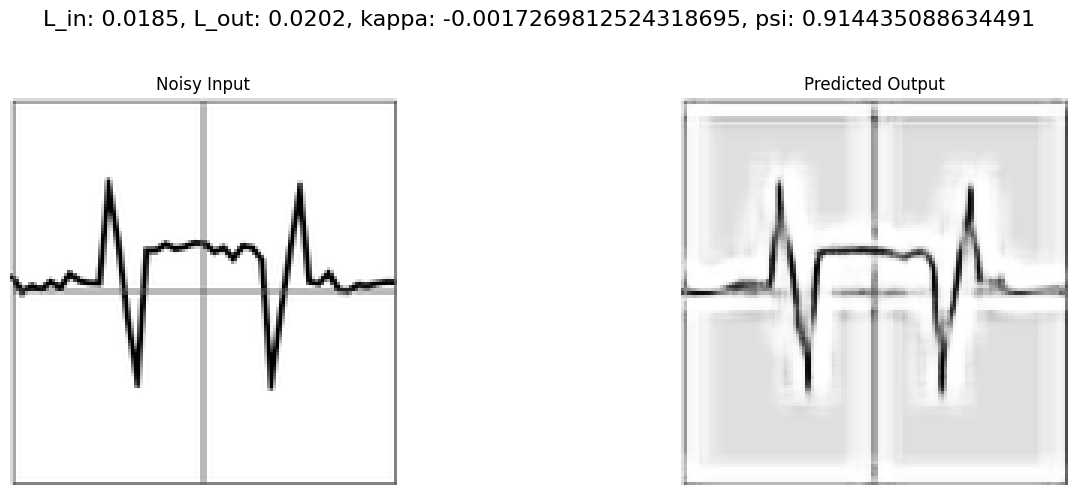

In [18]:
# Пример использования


image_path = "DATASETS/DATASET_2/fig1/1.png"  
clear_path = "DATASETS/DATASET_2/truefig1/1.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_2/fig2/1.png"  
clear_path = "DATASETS/DATASET_2/truefig2/2.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_2/fig3/1.png"  
clear_path = "DATASETS/DATASET_2/truefig3/3.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_2/fig4/1.png"  
clear_path = "DATASETS/DATASET_2/truefig4/4.png"
predict_image_with_losses(model, image_path, clear_path)

image_path = "DATASETS/DATASET_2/fig5/1.png"  
clear_path = "DATASETS/DATASET_2/truefig5/5.png"
predict_image_with_losses(model, image_path, clear_path)

In [51]:
#model.save("SAVED_MODELS/model_19.11.24_ds3_1.keras")